# Тестовое задание
Написать и обучить модель-автокодировщик на датасете на выбор: CIFAR10, CIFAR100.
Обучить модель-классификатор на латентных представлениях обученного автокодировщика.


### Рекомендуемые шаги для выполнения задания

**Шаг 1.** Подготовка инфраструктуры.

Создание окружения, организация структуры репозитория, загрузка датасетов.

**Шаг 2.** Реализовать модель-автоенкодер.

Выбрать архитектуру и реализовать ее совместно с процедурой обучения, подходящей для выбранного датасета.
Важно обратить внимание на выбор размерность скрытого состояния. Обосновать свой выбор.

**Шаг 3.** Обучить автоенкодер.

Нужно обучить реализованную архитектуру на скаченном датасете.
Оценить качество работы модели.

**Шаг 4.** Реализовать модель-классификатор.

Реализовать небольшую модель классификатор на скрытых представлениях уже обученного автоенкодера.
Реализовать пайплайн обучения данной модели.

**Шаг 5.** Обучение модели классификатора и визуализация результатов.

На этом шаге требуется обучить модель классификатор и оценить ее качество.
Подумайте, в каком виде было бы удобно провести демонстрацию результатов?

**Шаг 6.** Выводы и идеи.

Проведите анализ результатов, сделайте несколько выводов на основе полученных рузультатов.
Предложите свои идеи, как можно улучшить текущие результаты.


---
## 0. Загрузка библиотек и датасета

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torchsummary import summary
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

import warnings
warnings.filterwarnings("ignore")

seed = 128
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Проверка CUDA
torch.cuda.is_available()

True

In [2]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
valid_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
train_dataset, valid_dataset

Files already downloaded and verified
Files already downloaded and verified


(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset CIFAR10
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: ToTensor())

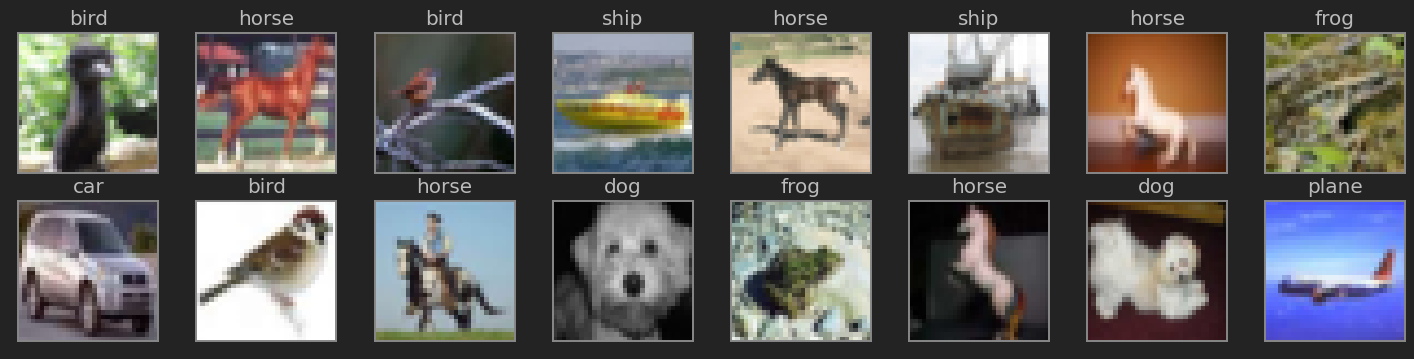

In [3]:
# Посмотрим, что внутри, добавим описание меток из оф. описания
labels_dict = {
    0: "plane",
    1: "car",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}

figure = plt.figure(figsize=(18, 4))
cols, rows = 8, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_dict[label])
    plt.xticks([]), plt.yticks([])
    plt.imshow(np.transpose(img, axes=(1, 2, 0)))
plt.show()

In [213]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=512,
                                           shuffle=True,
                                          )
valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                                          batch_size=512,
                                          shuffle=False, 
                                         )

---
## 1. Реализация структуры сети автоэнкодера на основе VGG11

In [11]:
transfer_model = models.vgg11(pretrained=True)
transfer_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [24]:
# VGG уже с обученными весами и обычно первые слои в моделях с похожими задачами схожи между собой - извлекают низкоуровневые фичи.
# Поэтому зафиксируем слои VGG и не будем их обучать.
for param in transfer_model.features.parameters():
    param.requires_grad = False
transfer_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [210]:
class Encoder(nn.Module):
    def __init__(self, hidden_dim):
        super(Encoder, self).__init__()
        self.vgg11 = transfer_model.features
        self.flat = nn.Flatten()
        self.fc = nn.Linear(512*1*1, 128)
        self.hidden = nn.Linear(128, hidden_dim)

    def forward(self, x):
        x = self.vgg11(x)
        
        x = self.flat(x)
        x = self.fc(x)
        x = F.relu(x)
        x = self.hidden(x)
        
        return x

class Decoder(nn.Module):
    def __init__(self, hidden_dim):
        super(Decoder, self).__init__()
        self.convt_1 = nn.ConvTranspose2d(512, 512, kernel_size=2, stride=1, padding=0)
        self.convt_2 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.convt_3 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=1, padding=0)
        self.convt_4 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.convt_5 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2, padding=0)
        self.convt_6 = nn.ConvTranspose2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.convt_7 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2, padding=0)
        self.convt_8 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2, padding=0)
        self.convt_9 = nn.ConvTranspose2d(64, 3, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(128, 512*1*1)
        self.hidden = nn.Linear(hidden_dim, 128)
        self.unflat = nn.Unflatten(dim=1, unflattened_size=(512, 1, 1))
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.hidden(x)
        x = self.relu(x)
        x = self.fc(x)
        x = self.relu(x)
        x = self.unflat(x)
        
        x = self.convt_1(x)
        x = self.relu(x)
        
        x = self.convt_2(x)
        x = self.relu(x)
        
        x = self.convt_3(x)
        x = self.relu(x)
        
        x = self.convt_4(x)
        x = self.relu(x)
        
        x = self.convt_5(x)
        x = self.relu(x)
        
        x = self.convt_6(x)
        x = self.relu(x)

        x = self.convt_7(x)
        x = self.relu(x)
        
        x = self.convt_8(x)
        x = self.relu(x)
        
        x = self.convt_9(x)
        x = self.relu(x)
        
        return x

class AutoEncoder(nn.Module):
    def __init__(self, hidden_dim):
        super(AutoEncoder, self).__init__()
        self.enc = Encoder(hidden_dim)
        self.dec = Decoder(hidden_dim)
        
    def forward(self, x):
        x = self.enc(x)
        x = self.dec(x)
        
        return x

In [225]:
# Запомним device для дальнейшего использования
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [212]:
model = AutoEncoder(hidden_dim=4).to(device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4          [-1, 128, 16, 16]          73,856
              ReLU-5          [-1, 128, 16, 16]               0
         MaxPool2d-6            [-1, 128, 8, 8]               0
            Conv2d-7            [-1, 256, 8, 8]         295,168
              ReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         590,080
             ReLU-10            [-1, 256, 8, 8]               0
        MaxPool2d-11            [-1, 256, 4, 4]               0
           Conv2d-12            [-1, 512, 4, 4]       1,180,160
             ReLU-13            [-1, 512, 4, 4]               0
           Conv2d-14            [-1, 51

---
## 2. Обучение автоэнкодера

In [214]:
hidden_dimensions = [8]

for dim in hidden_dimensions:
    history = pd.DataFrame(columns=['hidden_dimension', 'epoch', 'train_loss', 'valid_loss'])
    model = AutoEncoder(hidden_dim=dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.MSELoss()  

    print(f'Start training with {dim}-sized hidden dimension')
    for epoch in range(101):  
        
        # TRAIN BLOCK
        model.train()
        loss_train = 0
        for i, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs.to(device))
            loss = criterion(outputs, inputs.to(device))
            loss.backward()
            optimizer.step()
            loss_train += loss.item()

            del inputs, labels
            gc.collect()
            torch.cuda.empty_cache()
            
        # EVAL BLOCK
        model.eval()
        loss_valid = 0
        with torch.no_grad():
            for X, y in valid_loader:
                output = model(X.to(device))
                loss = criterion(output, X.to(device))
                loss_valid += loss.item()
                
                del X, y
                gc.collect()
                torch.cuda.empty_cache()
            
        history.loc[len(history)] = [dim, epoch, loss_train, loss_valid]
    
        if (epoch % 10 == 0):
            print(f"Epoch: {epoch}, train_loss: {loss_train / len(train_loader)}, valid_loss: {loss_valid / len(valid_loader)}")
    
    torch.save(model.to('cpu').state_dict(), f'./Models/VGGmodel_{dim}-hidden_dim.pt')   
    history.to_csv(f'./History/VGGhistory_{dim}-hidden_dim.csv')
    print(f'Training with {dim}-sized hidden dimension is finished!')
    print('=' * 80)

model = model.to('cpu')
print(f'Training is finished!')

Start training with 8-sized hidden dimension
Epoch: 0, train_loss: 0.0861368772808377, valid_loss: 0.05129883521132999
Epoch: 10, train_loss: 0.037730389935824706, valid_loss: 0.040234987520509295
Epoch: 20, train_loss: 0.03545170311481898, valid_loss: 0.040034979581832886
Epoch: 30, train_loss: 0.0340501080260022, valid_loss: 0.040984606439316715
Epoch: 40, train_loss: 0.03278691836327087, valid_loss: 0.04178354902951806
Epoch: 50, train_loss: 0.0312952954777097, valid_loss: 0.042285552593293016
Epoch: 60, train_loss: 0.02945214180090955, valid_loss: 0.04379936597413487
Epoch: 70, train_loss: 0.026774981222648656, valid_loss: 0.04604641444705151
Epoch: 80, train_loss: 0.02407271884211147, valid_loss: 0.0474514028540364
Epoch: 90, train_loss: 0.021672087856603944, valid_loss: 0.049343164182371564
Epoch: 100, train_loss: 0.01962516326030702, valid_loss: 0.05085527579541559
Training with 8-sized hidden dimension is finished!
Training is finished!


In [238]:
history = pd.DataFrame()
for path in glob.glob('./History/VGGhistory_*.csv'):
    history = pd.concat([history, pd.read_csv(path, index_col=0, dtype={'train_loss': 'float64', 'valid_loss': 'float64'})], axis=0)

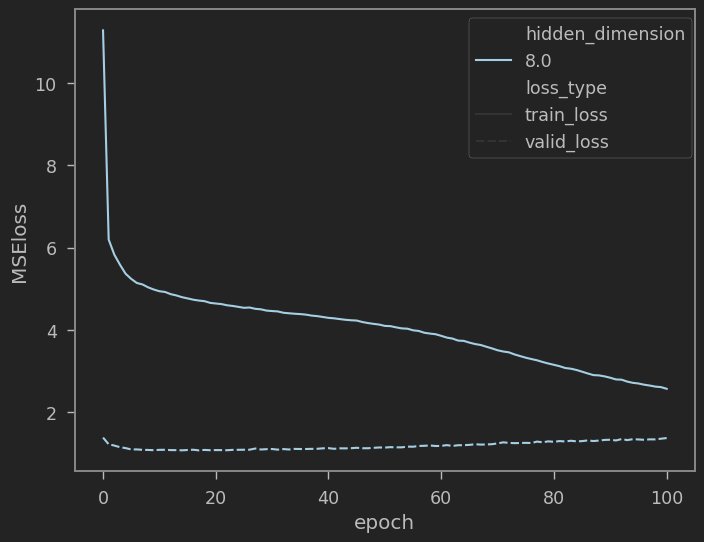

In [239]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=history.melt(id_vars=['hidden_dimension', 'epoch'], 
                               value_vars=['train_loss', 'valid_loss'], 
                               var_name='loss_type',
                               value_name='MSEloss'),
             x='epoch', 
             y='MSEloss',
             hue='hidden_dimension', 
             style='loss_type',
             palette='Paired',
            )
plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.show()

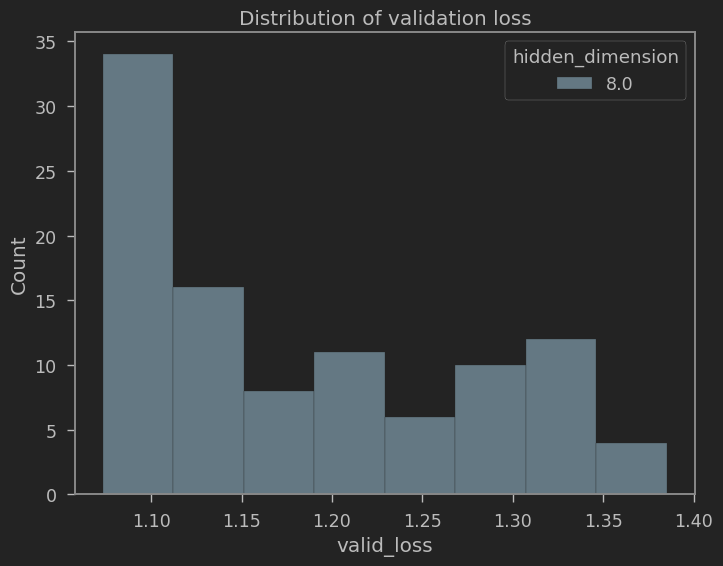

In [240]:
plt.figure(figsize=(8, 6))
sns.histplot(data=history, x='valid_loss', hue='hidden_dimension', palette='Paired')
plt.title('Distribution of validation loss')
plt.show()

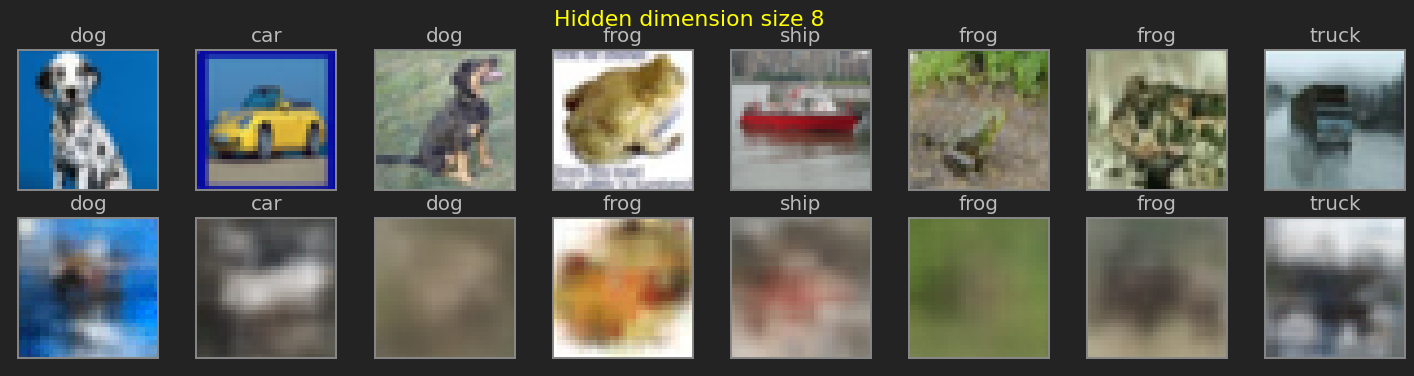

In [243]:
device = torch.device('cpu')
chosen_dim = 8
model = AutoEncoder(hidden_dim=chosen_dim)
model.load_state_dict(torch.load(f'./Models/VGGmodel_{chosen_dim}-hidden_dim.pt', map_location=device))

figure = plt.figure(figsize=(18, 4))
cols, rows = 8, 2
for i in range(1, cols + 1):
    sample_idx = torch.randint(len(valid_dataset), size=(1,)).item()
    img, label = valid_dataset[sample_idx]
    prediction = model(img[None, :, :, :]).detach().numpy()[0]
    prediction[prediction > 1.] = 1.

    figure.add_subplot(rows, cols, i)
    plt.title(labels_dict[label])
    plt.xticks([]), plt.yticks([])
    plt.imshow(np.transpose(img, axes=(1, 2, 0)))

    figure.add_subplot(rows, cols, i+8)
    plt.title(labels_dict[label])
    plt.xticks([]), plt.yticks([])
    plt.imshow(np.transpose(prediction, axes=(1, 2, 0)))

plt.suptitle(f'Hidden dimension size {chosen_dim}', color='yellow')
plt.show()

In [244]:
def draw_embeddings(X_embedded, targets, labels):
    plt.figure(figsize=(8, 6))
    for class_idx in range(np.max(targets) + 1):
        X_embedded_class = X_embedded[targets == class_idx, :]
        plt.scatter(X_embedded_class[:, 0], X_embedded_class[:, 1])
    plt.legend(labels, bbox_to_anchor=(1.01, 1.0))
    plt.grid(True)

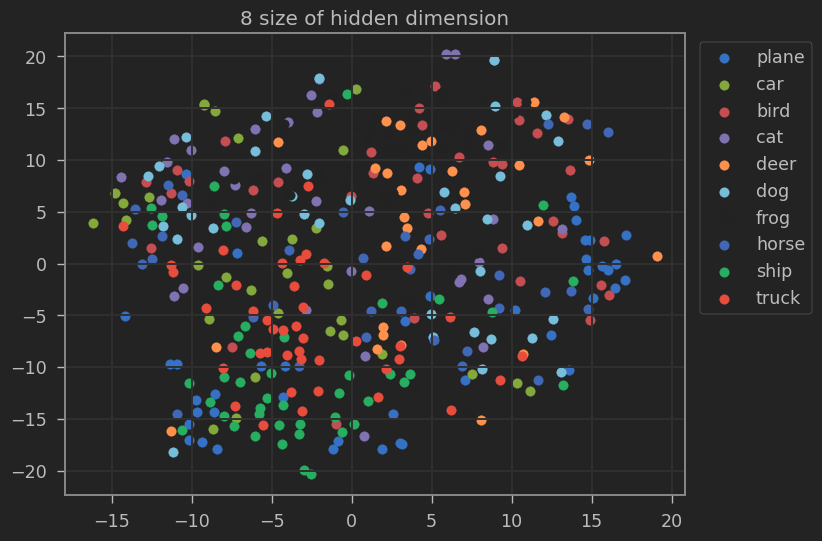

In [245]:
dataloader_iterator = iter(valid_loader)
x, y = next(dataloader_iterator)

model = AutoEncoder(hidden_dim=chosen_dim)
model.load_state_dict(torch.load(f'./Models/VGGmodel_{chosen_dim}-hidden_dim.pt', map_location=device))
pretrained_encoder = model.enc
test_embs = pretrained_encoder(x).detach().numpy()
test_embs_2D = TSNE(n_components=2).fit_transform(test_embs)
draw_embeddings(test_embs_2D, y.detach().numpy(), labels_dict.values())
plt.title(f'{chosen_dim} size of hidden dimension')

### Анализ автоэнкодера
Автоэнкодер немного переобучился, судя по лоссу тестовой выборки, тем не менее качество модели существенно лучше, чем было в сети, собранной в ручную, причем даже с существенно меньшим латентным пространством - 8. Посмотрим как сработает классификатор.

---
## 3. Реализация модели-классификатора

In [246]:
model = AutoEncoder(hidden_dim=chosen_dim)
model.load_state_dict(torch.load(f'./Models/VGGmodel_{chosen_dim}-hidden_dim.pt', map_location=device))

# Отрежем энкодер от модели автоэнкодера и зафиксируем его параметры
pretrained_encoder = model.enc
for param in pretrained_encoder.parameters():
    param.requires_grad = False
pretrained_encoder

Encoder(
  (vgg11): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


In [247]:
class ClassificationModel(nn.Module):
    def __init__(self, input_dim):
        super(ClassificationModel, self).__init__()
        self.enc = pretrained_encoder

        self.fc_1st = nn.Linear(input_dim, 512)
        self.fc_2nd = nn.Linear(512, 1024)
        self.fc_3rd = nn.Linear(1024, 10)

    def forward(self, x):
        x = self.enc(x)

        x = self.fc_1st(x)
        x = F.relu(x)
        
        x = self.fc_2nd(x)
        x = F.relu(x)
        
        x = self.fc_3rd(x)
        x = F.sigmoid(x)
        
        return x

In [248]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [249]:
clas_model = ClassificationModel(input_dim=chosen_dim).to(device)
summary(clas_model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4          [-1, 128, 16, 16]          73,856
              ReLU-5          [-1, 128, 16, 16]               0
         MaxPool2d-6            [-1, 128, 8, 8]               0
            Conv2d-7            [-1, 256, 8, 8]         295,168
              ReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         590,080
             ReLU-10            [-1, 256, 8, 8]               0
        MaxPool2d-11            [-1, 256, 4, 4]               0
           Conv2d-12            [-1, 512, 4, 4]       1,180,160
             ReLU-13            [-1, 512, 4, 4]               0
           Conv2d-14            [-1, 51

---
## 4.  Обучение модели-классификатора

In [250]:
optimizer = torch.optim.Adam(clas_model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

In [251]:
for epoch in range(31):  
    # TRAIN BLOCK
    clas_model.train()
    loss_train = 0
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = clas_model(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        loss_train += loss.item()

        del inputs, labels
        gc.collect()
        torch.cuda.empty_cache()

    # EVAL BLOCK
    clas_model.eval()
    loss_valid = 0.
    accuracy = 0.
    total = 0.
    with torch.no_grad():
        for X, y in valid_loader:
            output = clas_model(X.to(device))
            loss = criterion(output, y.to(device))
            loss_valid += loss.item()
            
            _, predicted = torch.max(clas_model(X.to(device)).data, 1)
            total += y.size(0)
            accuracy += (predicted == y.to(device)).sum().item()

            del X, y
            gc.collect()
            torch.cuda.empty_cache()

    if (epoch % 10 == 0):
        print(f"Epoch: {epoch}, train_loss: {loss_train / len(train_loader)}, valid_loss: {loss_valid / len(valid_loader)}, valid Accuracy: {(100 * accuracy / total)}%")

clas_model = clas_model.to('cpu')
torch.save(clas_model.state_dict(), './Models/VGGclassification_model.pt')   
print(f'Training is finished!')

Epoch: 0, train_loss: 1.9661174166293545, valid_loss: 1.9364269265422114, valid Accuracy: 40.44%
Epoch: 10, train_loss: 1.887931416962893, valid_loss: 1.914272180310002, valid Accuracy: 42.3%
Epoch: 20, train_loss: 1.8742428644922853, valid_loss: 1.9099235181455259, valid Accuracy: 42.43%
Epoch: 30, train_loss: 1.8616391857161776, valid_loss: 1.9107251432206895, valid Accuracy: 42.5%
Training is finished!


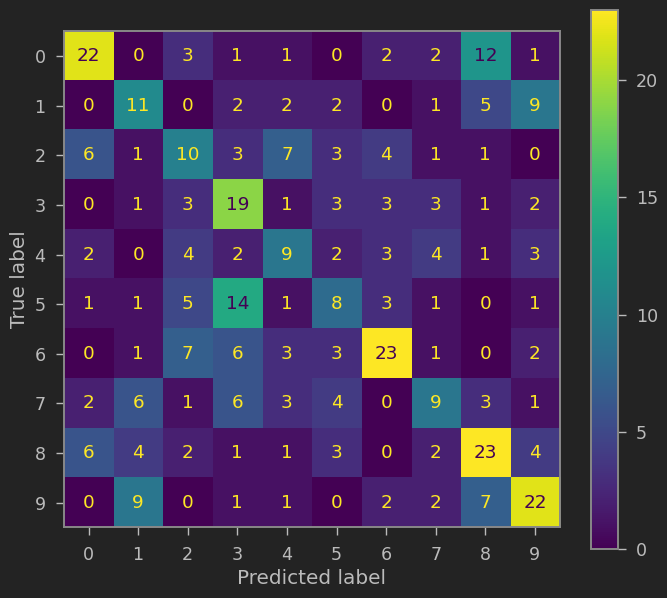

In [254]:
dataloader_iterator = iter(valid_loader)
x, y = next(dataloader_iterator)

_, predicted = torch.max(clas_model(x).data, 1)
cm = confusion_matrix(y, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
disp.plot( values_format ='.3g')
plt.show()

---
## 5. Выводы и идеи
Классификатор с энкодером VGG11 показал себя существенно лучше, чем небольшая сетка, собранная в ручную. Вероятно, дальнейшее увеличение глубины сети улучшит результат. Также, по ощущениям, можно сжать латентное пространство еще сильнее (например, до 4), вполне возможно, что его будет достаточно для данного датасета. Для улучшения качества классификатора можно попробовать усложнить блок сети классификации (fully connected layers).